In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge,Lasso,SGDRegressor
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
train_df = pd.read_csv('train_df_after_prep.csv', index_col='id')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   milage                          188533 non-null  int64  
 1   fuel_type                       188533 non-null  object 
 2   accident                        188533 non-null  int64  
 3   price                           188533 non-null  int64  
 4   horse_power                     188533 non-null  float64
 5   engine_size                     188533 non-null  float64
 6   cylinder                        188533 non-null  float64
 7   transmission_speed              188533 non-null  float64
 8   transmission_type               188533 non-null  object 
 9   car_age                         188533 non-null  int64  
 10  yearly_mileage                  188533 non-null  float64
 11  model_class                     188533 non-null  object 
 12  brand_cat            

In [4]:
X = train_df.drop('price', axis=1)
y = train_df['price'].copy()

In [5]:
num_features = X.select_dtypes(exclude='object').columns
cat_1hot_features = ['fuel_type', 'transmission_type', 'ext_col_cat', 'int_col_cat']
cat_ord_features = ['model_class', 'brand_cat']

pipeline = ColumnTransformer([('num', StandardScaler(), num_features), 
                              ('cat_1hot', OneHotEncoder(), cat_1hot_features),
                              ('model_class', OrdinalEncoder(categories=[['Base', 'Mid-Range', 'Performance/Sport', 'Luxury']]), ['model_class']),
                              ('brand_cat', OrdinalEncoder(categories=[['Economy', 'Mainstream', 'Premium', 'Luxury', 'Supercars']]), ['brand_cat'])
                              ])
X = pipeline.fit_transform(X)

Nhận xét: 
- Hệ số tương quan Pearson của các numerical features so với price thấp (trong file FeatureEngineering)
- Có 4 nominal features
- Có 2 ordinal features là brand_cat và model_class, tuy nhiên chỉ có brand_cat là phân bố hợp lý, còn model_class phân bố bị ngược ở tập train
(Thông qua plot ở file FeatureEngineering)

Do đó, sử dụng các mô hình tuyến tính trực tiếp sẽ không đạt hiệu quả cao trong bài toán này.
Ở phần 1.1 đến 1.3 sau đây chúng tôi đã tìm cách tối ưu các linear model (được thực hiện trước khi đưa ra các nhận xét trên) nên kết quả không có tiến triển. Do đó bạn đọc có thể chuyển đến phần 1.4 tối ưu tham số của RandomForestRegressor

# 1. Lựa chọn (Tối ưu) tham số

Sử dụng tập train để lựa chọn tham số:
- Ridge, Lasso: `alpha`
- SGD: `learning_rate`, `epochs`, `regularization strength`
- RandomForest: `n_estimators`, `max_features`, `max_depth`


Ta sẽ sử dụng chiến lược cross_validation trong bước này

In [7]:
def cross_validation(estimator,param_grid,X):

    grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X, y)
    cvres = grid_search.cv_results_
    
    # Compute RMSE for each fold (test and train)
    test_rmse_folds = [
        [np.sqrt(-cvres[f"split{i}_test_score"][j]) for i in range(5)] 
        for j in range(len(cvres["params"]))
    ]
    train_rmse_folds = [
        [np.sqrt(-cvres[f"split{i}_train_score"][j]) for i in range(5)] 
        for j in range(len(cvres["params"]))
    ]
    
    # Calculate mean and std RMSE
    results_df = pd.DataFrame({
        'params': cvres["params"],
        'mean_test_rmse': [np.mean(rmse) for rmse in test_rmse_folds],
        'std_test_rmse': [np.std(rmse) for rmse in test_rmse_folds],
        'mean_train_rmse': [np.mean(rmse) for rmse in train_rmse_folds],
        'std_train_rmse': [np.std(rmse) for rmse in train_rmse_folds],
    })
    
    sorted_df = results_df.sort_values(by='mean_test_rmse', ascending=True)
    
    return sorted_df

# 1.1. Đánh giá hiệu quả của các giá trị `alpha` trong `Ridge`

In [33]:
ridge_params = [{'alpha':[0.0001,0.001,0.01,0.1,1,10,100]}]

In [34]:
ridge = Ridge()
assessment_table = cross_validation(ridge,ridge_params,X)
assessment_table

,params,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
5,{'alpha': 10},73992.962006,3658.390288,74052.174490,890.012459
4,{'alpha': 1},73993.049534,3658.142172,74052.129472,890.010374
3,{'alpha': 0.1},73993.063122,3658.115854,74052.128783,890.010350
2,{'alpha': 0.01},73993.064558,3658.113206,74052.128775,890.010349
1,{'alpha': 0.001},73993.064703,3658.112941,74052.128775,890.010349
0,{'alpha': 0.0001},73993.064717,3658.112915,74052.128775,890.010349
6,{'alpha': 100},73993.120113,3660.300431,74053.407881,890.046408


Các giá trị alpha đều cho các giá trị RMSE ở cả tập train và test ngang nhau về cả mean và std.
Ta sẽ lấy alpha = 10.

# 1.2. Đánh giá hiệu quả của các giá trị `alpha` trong `Lasso` và thử tối ưu bằng cách loại bỏ các attribute có thể không quan trọng

In [24]:
lasso_params = [{'alpha':[0.1,1,10,100]}]

# 1.2.1. Đánh giá hiệu quả các giá trị alpha

In [25]:
lasso = Lasso()
cross_validation(lasso,lasso_params,X)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.798e+11, tolerance: 9.448e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e+12, tolerance: 9.172e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

           params  mean_test_rmse  std_test_rmse  mean_train_rmse  \
2   {'alpha': 10}    73992.951588    3658.083184     74053.400654   
1    {'alpha': 1}    73992.962061    3658.137362     74052.190221   
0  {'alpha': 0.1}    73993.032541    3658.120701     74052.130179   
3  {'alpha': 100}    74027.095777    3665.774146     74093.542003   

   std_train_rmse  
2      889.970822  
1      890.004380  
0      890.010270  
3      888.266206  


Nhận xét cũng tương tự như nhận xét với Ridge.
Lấy alpha = 10.

# 1.2.2. Thử tối ưu bằng cách loại bỏ các thuộc tính của đầu vào mà coef_ của Lasso tại đó = 0

In [9]:
lasso2 = Lasso(alpha = 10)
lasso2.fit(X,y)

Lasso(alpha=10)

In [10]:
lasso2.coef_

array([-1.99022833e+04, -1.47425595e+03,  7.16458676e+03,  6.29243931e+03,
       -3.91703259e+03,  4.03251541e+02,  0.00000000e+00, -8.13959530e+00,
        1.35924946e+04, -2.33438823e+02, -1.21084493e+04,  1.47008742e+03,
        4.67913988e+03,  2.63720776e+03, -3.46956215e+03,  1.34075005e+03,
       -1.93424825e+03, -4.91325176e+03, -8.43206004e+02,  4.89649410e+04,
       -1.36821516e+02,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        2.14961472e+03,  0.00000000e+00, -7.17332178e+02, -1.87948181e+03,
        1.57134143e+02,  7.89122670e+03, -0.00000000e+00,  3.20108781e+04,
       -0.00000000e+00, -0.00000000e+00, -1.99032873e+03,  1.33998819e+03,
       -1.26597568e+03,  9.05216732e+03, -5.21672051e+02,  5.18596399e+03,
        1.70422402e+03, -2.25367001e+03, -3.14446888e+02,  5.79447978e+03])

In [11]:
X[1].shape

(44,)

In [13]:
import numpy as np
import pandas as pd

def filter_features(column_transformer, model_coef):
    """
    Filters out features with coefficients of 0 from the input data.

    Parameters:
    - column_transformer: The fitted ColumnTransformer used to preprocess data.
    - model_coef: The coefficients from the trained Lasso model.

    Returns:
    - selected_features: List of index of feature with zero coefficients.
    """
    # Get feature names from the ColumnTransformer
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(columns))
        else:
            feature_names.extend(columns)

    # Ensure feature_names aligns with coef_
    feature_names = np.array(feature_names)

    # Identify zero coefficients
    zero_indices = np.where(model_coef == 0)[0]

    feature_names = feature_names[zero_indices]

    # Filter out features corresponding to zero coefficients
    return zero_indices,feature_names


zero_features,zero_features_names = filter_features(pipeline, lasso2.coef_)
zero_features,zero_features_names

(array([ 6, 21, 22, 23, 25, 30, 32, 33]),
 array(['car_age', 'transmission_type_DCT',
        'transmission_type_Electronically Controlled',
        'transmission_type_Fixed Gear', 'transmission_type_Overdrive',
        'ext_col_cat_Orange', 'ext_col_cat_Purple',
        'ext_col_cat_Red/Maroon'], dtype='<U43'))

In [14]:
filtered_X = np.delete(X, zero_features, axis=1)
filtered_X.shape

(188533, 36)

In [15]:
lasso2 = Lasso()
cross_validation(lasso2,lasso_params,filtered_X)

           params  mean_test_rmse  std_test_rmse  mean_train_rmse  \
0  {'alpha': 0.1}    73992.511543    3657.769039     74052.512830   
1    {'alpha': 1}    73992.485451    3657.821839     74052.522121   
2   {'alpha': 10}    73992.905764    3658.049505     74053.434126   
3  {'alpha': 100}    74027.095291    3665.773683     74093.541806   

   std_train_rmse  
0      889.958789  
1      889.958669  
2      889.955683  
3      888.266463  


So sánh hai tập giá trị RMSE ta thấy RMSE gần như không thay đổi so với lúc chưa optimize X.

# 1.3. Đánh giá hiệu quả của các giá trị `learning_rate`, `epochs`, `regularization strength` khi sử dụng `SGDRegressor`

1.3.1. Đánh giá hiệu quả của giá trị learning_rate

In [8]:
param_grid = [{
    'eta0': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0], #Cac gia tri khoi tao cua learning_rate
    'learning_rate': ['constant', 'invscaling']  #learning_rate schedule
}]

In [9]:
sgd_reg = SGDRegressor()
cross_validation(sgd_reg,param_grid,X)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fi

                                             params  mean_test_rmse  \
5    {'eta0': 0.001, 'learning_rate': 'invscaling'}    7.399422e+04   
0      {'eta0': 1e-05, 'learning_rate': 'constant'}    7.400200e+04   
3   {'eta0': 0.0001, 'learning_rate': 'invscaling'}    7.400508e+04   
2     {'eta0': 0.0001, 'learning_rate': 'constant'}    7.402028e+04   
7     {'eta0': 0.01, 'learning_rate': 'invscaling'}    7.411580e+04   
1    {'eta0': 1e-05, 'learning_rate': 'invscaling'}    7.422395e+04   
4      {'eta0': 0.001, 'learning_rate': 'constant'}    7.430876e+04   
9      {'eta0': 0.1, 'learning_rate': 'invscaling'}    7.492569e+04   
6       {'eta0': 0.01, 'learning_rate': 'constant'}    7.999956e+04   
11     {'eta0': 1.0, 'learning_rate': 'invscaling'}    8.053669e+04   
8        {'eta0': 0.1, 'learning_rate': 'constant'}    8.417210e+11   
10       {'eta0': 1.0, 'learning_rate': 'constant'}    1.824013e+13   

    std_test_rmse  mean_train_rmse  std_train_rmse  
5    3.662958e+03     7

Giá trị tối ưu của eta0 (initial learning_rate value) là 0.001 với learning_rate schedule là invscaling.

1.3.2. Đánh giá hiệu quả của các giá trị epochs

In [24]:
epoch_params = [{'max_iter':[1000,2000,10000,100000]}]

In [25]:
sgd_reg = SGDRegressor(eta0 = 0.001,learning_rate="invscaling")
cross_validation(sgd_reg,epoch_params,X)

                 params  mean_test_rmse  std_test_rmse  mean_train_rmse  \
1    {'max_iter': 2000}    73998.311931    3662.966116     74063.721941   
0    {'max_iter': 1000}    74001.175458    3660.044699     74064.699611   
2   {'max_iter': 10000}    74004.710621    3648.340595     74065.355373   
3  {'max_iter': 100000}    74008.158293    3654.446476     74067.673972   

   std_train_rmse  
1      892.864537  
0      895.452012  
2      892.654407  
3      891.989444  


Các giá trị trung bình và độ lệch chuẩn của RMSE tương ứng với mỗi epoch gần như ngang nhau.
Ta sẽ chọn giá trị epoch = 1000.

1.3.3. Đánh giá độ hiệu quả của Regularization Strength l1, l2, elasticnet

In [28]:
penalty_params = [{"penalty":['l1','l2','elasticnet']}]

In [29]:
sgd_reg = SGDRegressor(eta0 = 0.001,learning_rate="invscaling",max_iter=1000)
cross_validation(sgd_reg,penalty_params,X)

                      params  mean_test_rmse  std_test_rmse  mean_train_rmse  \
0          {'penalty': 'l1'}    74003.443895    3651.586047     74062.398529   
2  {'penalty': 'elasticnet'}    74004.273212    3663.073352     74066.674384   
1          {'penalty': 'l2'}    74007.732983    3657.669774     74063.563998   

   std_train_rmse  
0      891.326552  
2      885.806643  
1      887.524491  


Các giá trị trung bình và độ lệch chuẩn của RMSE tương ứng với mỗi loại penalty gần như ngang nhau.
Ta sẽ chọn giá trị penalty = elasticnet.

# 1.4. Đánh giá độ hiệu quả của các giá trị `n_estimators`, `max_features`, `max_depth` khi sử dụng `RandomForest`

1.4.1. Đánh giá độ hiệu quả của các giá trị `n_estimators`, `max_features` ,`max_depth`

In [30]:
param_grid = [{"n_estimators":[50,80,100],"max_features":[2,4,8,12],"max_depth":[2,4,8,12,None]}]

In [31]:
RF_reg = RandomForestRegressor()
assessment_table = cross_validation(RF_reg,param_grid,X)
assessment_table

,params,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
35,"{'max_depth': 8, 'max_features': 12, 'n_estima...",73049.467147,3715.654323,67539.107291,927.765903
34,"{'max_depth': 8, 'max_features': 12, 'n_estima...",73099.867564,3671.581676,67428.064584,825.188483
32,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",73147.406475,3711.482197,68819.292704,930.427022
33,"{'max_depth': 8, 'max_features': 12, 'n_estima...",73151.038189,3680.314284,67421.696687,814.351088
31,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",73181.217362,3698.427757,68781.461456,946.375401
30,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",73188.606578,3735.769568,68917.196728,935.519105
41,"{'max_depth': 12, 'max_features': 4, 'n_estima...",73231.500919,3740.402079,62646.285913,760.849763
40,"{'max_depth': 12, 'max_features': 4, 'n_estima...",73232.075498,3743.990299,62704.589388,840.012190
29,"{'max_depth': 8, 'max_features': 4, 'n_estimat...",73339.780571,3679.343856,71169.910383,858.579124
39,"{'max_depth': 12, 'max_features': 4, 'n_estima...",73357.584024,3742.996129,62585.766196,837.152364


# 1.5. Đánh giá độ hiệu quả của các giá trị `n_estimators`, `max_depth` trong XGBoost

1.5.1. Đánh giá độ hiệu quả của các giá trị `n_estimators`, `max_depth`

In [28]:
from xgboost import XGBRegressor

param_grid = [{"n_estimators":[10,20,30,40,50,60,70,80,90,100],"max_depth":[2,3,4,5,6,7,8,9,10,20,30]}]

# Initialize XGBoost regressor
XGB_reg= XGBRegressor(
    objective='reg:squarederror',  # Use squared error for regression
    learning_rate=0.05,           # Step size shrinkage
    subsample=0.8,                # Randomly sample training data
    colsample_bytree=0.8,         # Randomly sample features for each tree
    random_state=42
)

assessment_table = cross_validation(XGB_reg,param_grid,X)
assessment_table

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,params,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
29,"{'max_depth': 4, 'n_estimators': 100}",72884.705244,3662.100625,71874.917514,908.522479
38,"{'max_depth': 5, 'n_estimators': 90}",72889.254074,3692.791250,70555.748294,937.086826
37,"{'max_depth': 5, 'n_estimators': 80}",72898.624071,3693.692484,70785.726599,951.501694
39,"{'max_depth': 5, 'n_estimators': 100}",72901.513928,3689.917723,70294.951923,945.942523
28,"{'max_depth': 4, 'n_estimators': 90}",72902.952693,3671.717573,72005.335842,896.245715
...,...,...,...,...,...
107,"{'max_depth': 30, 'n_estimators': 80}",79336.790782,3698.722654,20604.438324,865.544941
98,"{'max_depth': 20, 'n_estimators': 90}",79370.086138,3656.399404,21792.047326,834.151952
99,"{'max_depth': 20, 'n_estimators': 100}",79729.562138,3667.133952,20429.496309,921.567670
108,"{'max_depth': 30, 'n_estimators': 90}",79807.114491,3674.136663,18896.956702,968.608852


# 2. So sánh các mô hình
- Sau khi chọn được bộ tham số tốt cho các mô hình, ta huấn luyện trên toàn bộ tập train.
- Ta sẽ lấy SGDRegressor để đại diện cho các mô hình LinearRegression và so sánh nó với RandomForest

In [7]:
SGD_reg = SGDRegressor(alpha = 10,eta0 = 0.001,learning_rate="invscaling",max_iter = 1000)
RF_reg = RandomForestRegressor(n_estimators=100,max_features = 8,max_depth = 8)

Ta sẽ so sánh dựa trên hai độ đo:
- Tính khả mở (Scalability)
- RMSE score

# 2.1. So sánh các mô hình dựa trên tính khả mở (Scalability)

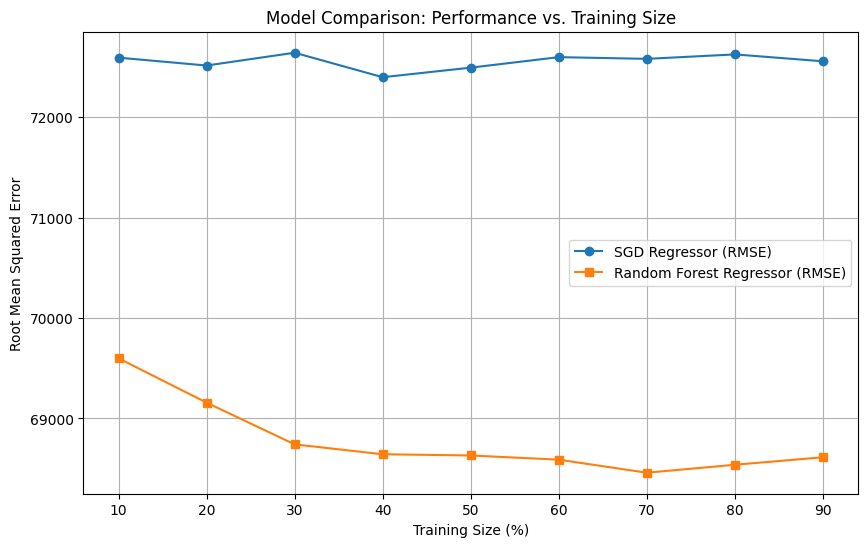

In [ ]:
# Split train_data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare to record performance
training_sizes = np.linspace(0.1, 0.9, 9)  # 10% to 90% of the training data
sgd_scores, rf_scores = [], []

# Evaluate both models on varying training sizes
for frac in training_sizes:
    X_train_frac, _, y_train_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=42)
    
    SGD_reg.fit(X_train_frac, y_train_frac)
    y_pred_sgd = SGD_reg.predict(X_val)
    sgd_scores.append(np.sqrt(mean_squared_error(y_val, y_pred_sgd)))
    
    RF_reg.fit(X_train_frac, y_train_frac)
    y_pred_rf = RF_reg.predict(X_val)
    rf_scores.append(np.sqrt(mean_squared_error(y_val, y_pred_rf)))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(training_sizes * 100, sgd_scores, marker='o', label='SGD Regressor (RMSE)')
plt.plot(training_sizes * 100, rf_scores, marker='s', label='Random Forest Regressor (RMSE)')
plt.xlabel('Training Size (%)')
plt.ylabel('Root Mean Squared Error')
plt.title('Model Comparison: Performance vs. Training Size')
plt.legend()
plt.grid()
plt.show()

Nhận xét: SGDRegressor có tính khả mở kém hơn RandomForestRegressor

# 2.2. So sánh các mô hình dựa trên RMSE score

In [11]:
test_df = pd.read_csv('test_df_after_prep.csv', index_col='id')

In [12]:
X_test = pipeline.transform(test_df)
SGD_reg.fit(X,y)
RF_reg.fit(X,y)

RandomForestRegressor(max_depth=8, max_features=8)

In [13]:
y_pred_SGD = SGD_reg.predict(X_test)
y_pred_RF = RF_reg.predict(X_test)

In [17]:
SGD_submission_file = test_df.reset_index()[['id']]
SGD_submission_file['price'] = y_pred_SGD
SGD_submission_file.set_index('id', inplace=True)
SGD_submission_file.to_csv('SGD_submission.csv')

In [16]:
RF_submission_file = test_df.reset_index()[['id']]
RF_submission_file['price'] = y_pred_RF
RF_submission_file.set_index('id', inplace=True)
RF_submission_file.to_csv('RF_submission.csv')

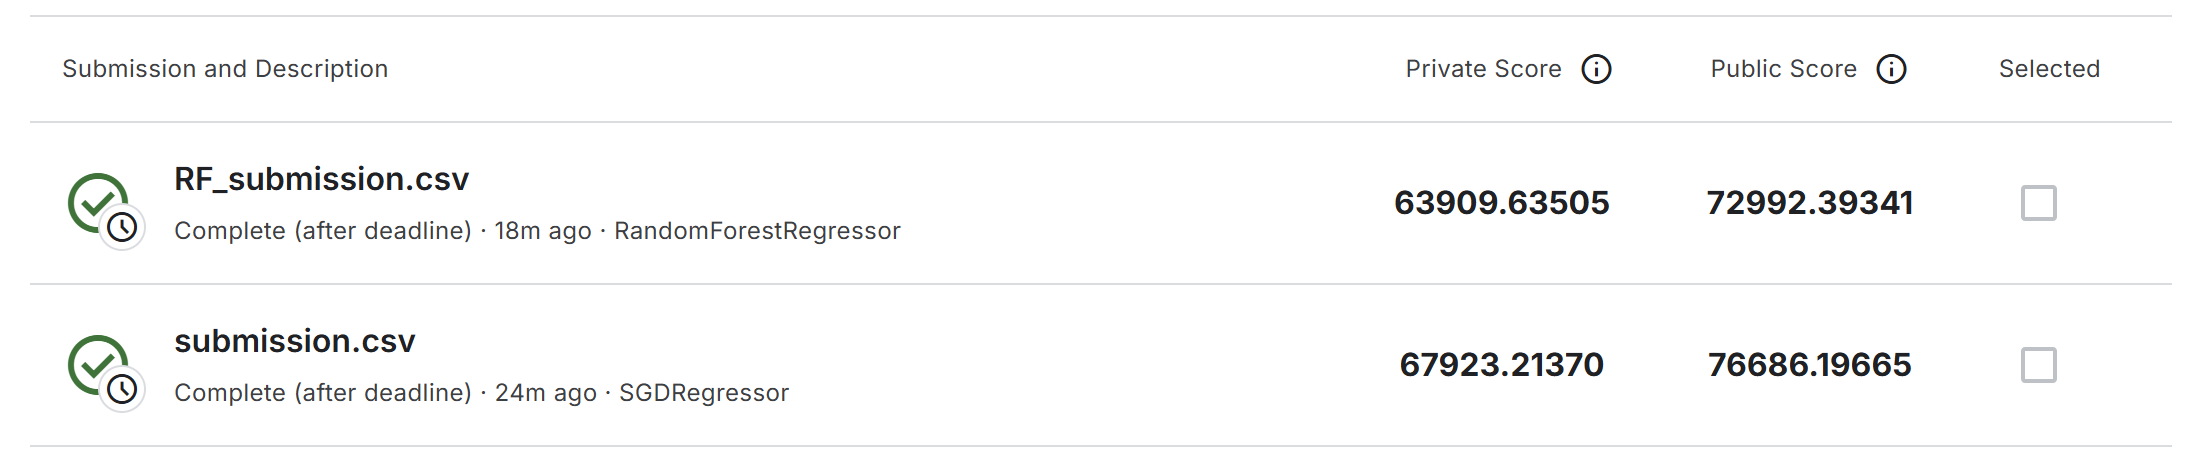

Chú thích: Public Score chỉ tính score trên 20% dữ liệu trên tập test, còn Private Score tính score trên 80% dữ liệu của tập test.
So với xếp hạng Leaderboard trên kaggle, top 1 đạt 62917.05988, RF_submission khoảng top 1700 trên 3306 người tham gia.